<a href="https://colab.research.google.com/github/timbyles/ASX-Cointegration/blob/main/Pairs_Trading_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [66]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels
import statsmodels.api as sm
import math
import random
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

In [5]:
# Pull ASX data from github file. Note: ASX300 data current as of 16/09/2021.
url = 'https://raw.githubusercontent.com/timbyles/ASX-Cointegration/main/ASX300.csv'
df = pd.read_csv(url)

# Converts tickers to list
tickers = df["Code"].tolist()

# Concatenates tickers with .ax in order to be suitable for yfinance
for index,code in enumerate(tickers):
  tickers[index] = code + '.ax'

In [ ]:
# Pulls data from yfinance
data = yf.download(tickers, start="2018-01-01", end="2019-01-1")

In [7]:
# Takes the close prices of our data
data_close = data["Close"]

# Creates an empty dictionary to count exists of 'NaN'
nan_dict = {}

# Loop through dataframe to find which ticker sybomls have a NaN value.
for index, row in data_close.iteritems():
  for i in row:
    if np.isnan(i) == True:
      nan_dict[index] = 1

# Removes columns with NaN value
for key in nan_dict:
  data_close = data_close.drop(key, 1)

In [8]:
# Looks for cointegrated pairs

def find_cointegrated_pairs(data):
    
    # Creates matrices based of the number of stocks
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [10]:
# To save computational time, we can generate sample amount of stocks at random to test for cointegration.
# Otherwise samples to be tested (n(n-1))/2. For 300 stocks, 179400 combinations.
# This also prevents us from multiple comparison bias. Too many false positives.

sample = 10
random_index = []
i = 0

while i < 10:
  rand_int = random.randint(0, data_close.shape[1])
  if rand_int not in random_index:
    random_index.append(rand_int)
    i += 1

data_close_random = pd.DataFrame()

for r in random_index:
  temp_df = data_close.iloc[:, r]
  data_close_random = pd.concat([data_close_random, temp_df], axis=1)

In [77]:
scores, pvalues, pairs = find_cointegrated_pairs(data_close_random)

print(pairs)

[('NCM.AX', 'FMG.AX'), ('AMP.AX', 'BWP.AX'), ('FMG.AX', 'BKW.AX')]


NCM.AX vs FMG.AX
AMP.AX vs BWP.AX
FMG.AX vs BKW.AX


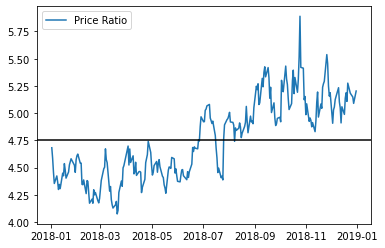

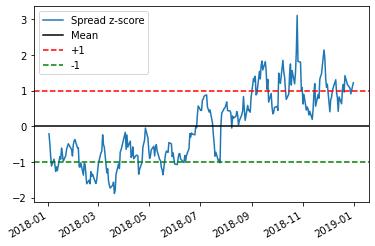

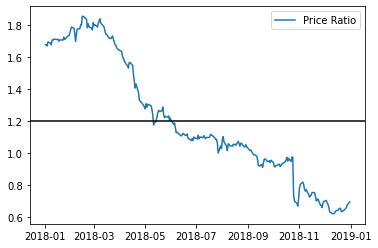

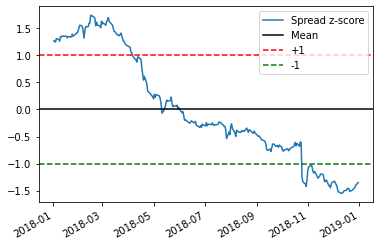

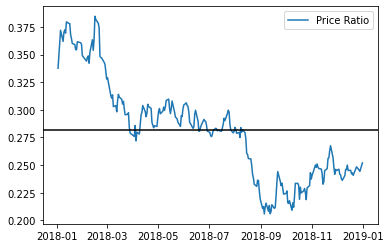

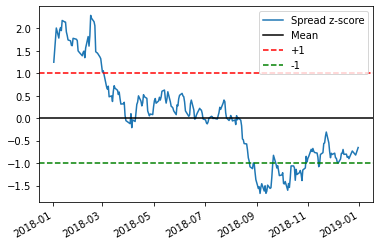

In [105]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

plt_index = 0

for pair in pairs:
  print(pair[0] + " vs " + pair[1])
  s1 = data_close_random[pair[0]]
  s2 = data_close_random[pair[1]]
  ratio = s1/s2
  plt.figure(plt_index)
  plt.plot(ratio)
  plt.axhline(ratio.mean(), color='black')
  plt.legend(['Price Ratio']);
  plt_index = plt_index + 1 
  plt.figure(plt_index)
  zscore(ratio).plot()
  plt.axhline(zscore(ratio).mean(), color='black')
  plt.axhline(1.0, color='red', linestyle='--')
  plt.axhline(-1.0, color='green', linestyle='--')
  plt.legend(['Spread z-score', 'Mean', '+1', '-1']);
  plt_index = plt_index + 1

In [30]:
# Check for stationarity
# Stationarity assumes mean is constant, std sev is constant and there is no seasonality.

def check_for_stationarity():
  return